# Assignment 2
### Author: Frank Schiro & Florian Mudekereza
### Course: CS 7420 Machine Learning
### Fall 2020

In [41]:
#---------- Packages -------------#
import numpy as np
import numpy.linalg as la
from sklearn import datasets
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy import special
import math
np.random.seed(11)
iris = datasets.load_iris()
bc = datasets.load_breast_cancer()
yes = 'ignore'
#---------------------------------#

## 1. Functions 

#### 1.1 MinimizeLogisticRegression

Outputs beta that minimizes logistic regression cost function

In [42]:
import warnings

# Minimize the logistic regression cost function given design matrix X,
# dependent variable Y, init cond beta(t=0)
def minimizeLogisticRegression(X, Y, beta):
    warnings.filterwarnings(yes)
    objOld = 10^9
    obj = 100
    output = []
    iterat = []
    iterations = 0
    while abs(objOld - obj) > 10^(-6) or np.isinf(obj):
        objOld = obj        
        Z = np.exp(- Y * np.matmul(X, beta))
        np.put(Z, np.where(np.isinf(Z)), 10^9)
        n = X.shape[0] 
        Z2 = Z / (1 + Z)
        gradE = np.array([
            np.matmul(Z2.transpose(), Y)
        ])
        for i in range(X.shape[1] - 1):
            gradE = np.append(gradE, np.matmul(Z2.transpose(), (Y * X[:, (i+1)])))
        gradE = - (1 / n) * gradE
        G = - gradE / la.norm(gradE)
        # stop criteria
        # f(x + tdx) < f(x) + alpha * t * gradF * G
        Tmin = 0
        Tmax = 1
        alpha = .1
        obj = (1 / n) * sum(np.log(1 + Z))
        while (Tmax - Tmin) > .00005:
            T = Tmin + (Tmax - Tmin) / 2
            betaTmp = beta + T * G
            Z = np.exp(-Y * np.matmul(X, betaTmp))
            objTmp = 1 / n * np.sum(np.log(1 + Z))
            stopCrit = objTmp > obj + alpha * T * np.matmul(gradE.transpose(), G)
            if not stopCrit:
                # this T point not too large so keep all to right
                Tmin = T
            else:
                Tmax = T    
        beta = beta + T * G
        Z = np.exp(- Y * np.matmul(X, beta))
        obj = 1 / n * np.sum(np.log(1 + Z))
        output.append(obj)
        iterations += 1
        iterat.append(iterations)
        if(iterations % 2000 == 0):
            pass 
    return [beta, output, iterat]

#### 1.2 MultiClassLogReg:
   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
For i = 1:number of classes  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
Set i = positive class  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
set not i = negative class  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
calculate coefficients beta for logistic regression

In [43]:
# Multiclass logistic regression 
# returns logistic regression coefficients for each class in Y
# for 3 class returns: 100, 010, 001
# where 0...0i0...0 is a logistic regression where class i is positive, all other class negative

def multiClassLogReg(X, Y, beta0):
    classes = np.unique(Y)
    out = []
    # negative1 should not be a class of solution set for this to work
    for i in range(len(classes)):
        y = Y.copy()
        np.put(y, np.where(y != classes[i]), -1)
        np.put(y, np.where(y == classes[i]), 1)
        out.append(minimizeLogisticRegression(X, y, beta0)[0])
    return(out)

#### 1.3 classifyMulticlassLogreg:
   
Classifies each sample in a multiple-class logistic regression.  
Output = class which has the highest probability
Input = array of array. Each sub-array is made of beta coefficients for each class


In [44]:
# input design matrix X, output of multiClassLogReg BETA
# output = classification of every row of logReg

def classifyMulticlassLogreg(X, BETA):
    out = []
    for beta in BETA:
        out.append(logReg(X, beta))
    return(np.argmax(out, 0))

#### 1.4 logReg

Outputs probability for positive class given coefficients beta and matrix of samples

In [45]:
# compute the probability x is in positive class given beta

def logReg(x, beta):
    z = np.exp(np.matmul(x, beta))
    # probability close to 1 returns infinity. 
    np.put(z, np.where(np.isinf(z)), 10^9)
    return(z / (1 + z))

#### 1.5 logRegClassify

Classifies each sample for a single class logistic regression

In [46]:
# classify a single class logistic regression

def logRegClassify(X, beta):
    out = logReg(X, beta)
    np.put(out, np.where(out > .5), 1)
    np.put(out, np.where(out <= .5), 0)
    return(out)

## 2 Cross-validation

For validation, we use the k-fold cross-validation method. 
More precisely, we use 5-fold cross-validation. 
In other words, we split the data 5 ways to train, test, and validate the model.

In [47]:
from sklearn.model_selection import KFold
X = iris.data.copy()
Y = iris.target.copy()

def crossval(X_train, X_test, Y_train, Y_test):
    #this is the cross-validation function
    
    n,m = X_train.shape 
    n1,m = X_test.shape
    X_train = np.hstack((np.ones((n,1)), X_train))
    X_test = np.hstack((np.ones((n1,1)), X_test))
    beta0 = np.ones(X_train.shape[1]) # initialize beta0 as all ones, 1 for each column of design matrix

    BETA = multiClassLogReg(X_train, Y_train, beta0)
    correct = np.sum(Y_test == classifyMulticlassLogreg(X_test, BETA))
    incorrect = np.sum(Y_test != classifyMulticlassLogreg(X_test, BETA))
    return correct/(correct+incorrect)

In [48]:
def accuracylog(X, k=5):
    # this implements the cross-validation with 5 folds
    
    kf = KFold(n_splits=k, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(X.data):
        X_train, X_test, Y_train, Y_test = X.data[train_index], X.data[test_index], \
                                            X.target[train_index], X.target[test_index]
        scores.append(crossval(X_train, X_test, Y_train, Y_test))
    return [np.mean(scores),scores]

In [52]:
# set height of bar graphs
bars1 = accuracylog(bc)[1]
bars2 = accuracylog(iris)[1]

# bar graph function
def bargraph(bars1,bars2,width=0.25):
    barWidth = width
    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r3 = [x + barWidth for x in r1]
    r2 = [x + barWidth for x in r3]
    r4 = [x + barWidth for x in r2]

    plt.bar(r1, bars1, color='orange', width=0.5, edgecolor='white', label='Breast Cancer', alpha=0.75)
    plt.bar(r2, bars2, color='purple', width=0.5, edgecolor='white', label='Iris', alpha=0.75)
    plt.bar(r3, bars2, color='white', width=0, edgecolor='white', label='')
    plt.bar(r4, np.ones(5), color='white', width=0.2,edgecolor='white', label='')
    # Add xticks on the middle of the group bars
    plt.xlabel('Folds', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1))], ['1', '2', '3', '4', '5'])
    axes = plt.gca()
    axes.set_ylim([0,1.2])

    # Create legend & Show graphic
    plt.legend(loc=1, prop={'size': 9.5})
    plt.savefig('bciris_iterations.png')
    plt.show()

### 2.1 Out-of-sample Predictions

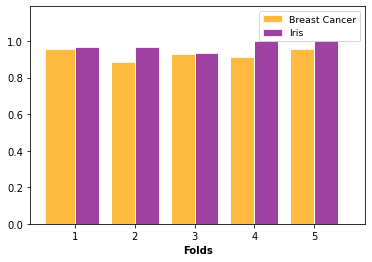

In [51]:
# Out-of-sample prediction bar graph
bargraph(bars1,bars2)

### 2.2 Different initialization

#### I. Iris dataset experiment

In [19]:
X = iris.data.copy()
n,m = X.shape
X = np.hstack((np.ones((n,1)), X))
Y = iris.target.copy()
np.put(Y, np.where(Y != 0), -1)
np.put(Y, np.where(Y == 0), 1)
beta0=np.random.rand(X.shape[1])*1.34 # random initial weight
beta= np.ones(X.shape[1])  # initial with all ones
o,output,t = minimizeLogisticRegression(X,Y,beta0)  # using random initial weights
o,output1,t1 = minimizeLogisticRegression(X,Y,beta) # using all 1's as initial weights

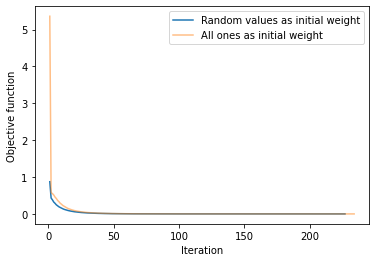

In [20]:
# Performance plot for iris data

plt.plot(t,output,label='Random values as initial weight',alpha=1)
plt.plot(t1,output1,label='All ones as initial weight',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Objective function')
plt.legend()
plt.savefig('iris_iterations.png')
plt.show()  

#### II. Breast Cancer dataset experiment

In [27]:
X = bc.data.copy()
n,m = X.shape
X = np.hstack((np.ones((n,1)), X))
Y = bc.target.copy()
np.put(Y, np.where(Y != 0), -1)
np.put(Y, np.where(Y == 0), 1)
beta0=np.random.rand(X.shape[1])*1.34               # random initial weights
beta= np.ones(X.shape[1])                           # initial with all ones
o,output,t = minimizeLogisticRegression(X,Y,beta0)  # using random initial weights
o,output1,t1 = minimizeLogisticRegression(X,Y,beta) # using all 1's as initial weights

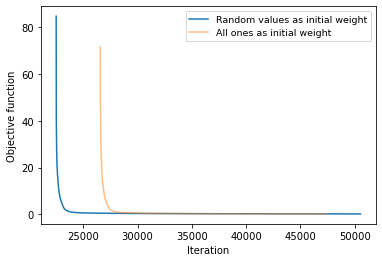

In [28]:
# Performance plot for breast cancer data

plt.plot(t,output,label='Random values as initial weight',alpha=1)
plt.plot(t1,output1,label='All ones as initial weight',alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Objective function')
plt.legend(loc=1, prop={'size': 9.5})
plt.savefig('bc_iterations.png')
plt.show()  